In [15]:
from src.depth import DepthModel
from src.warp import anim_frame_warp_3d, AnimArgs
import torch
import cv2
from matplotlib import pyplot as plt
import torch
from diffusers import StableDiffusionImg2ImgPipeline
import PIL
import numpy as np
from functools import reduce
import math
import src.py3d_tools as p3d
import torch
from einops import rearrange
from IPython import display

In [4]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image

In [5]:
depth_model = DepthModel(torch.device("cuda"), "../models/dpt_large_384.pt", False)

In [6]:
img = PIL.Image.open("../data/tower.jfif")
depth = depth_model.predict(img)

tensor(1.2481, device='cuda:0')


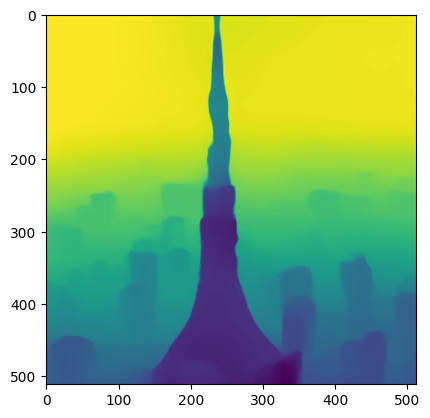

In [14]:
print(depth.min())
plt.imshow(depth.cpu())

In [39]:
np.sin(np.pi / 6)

0.49999999999999994

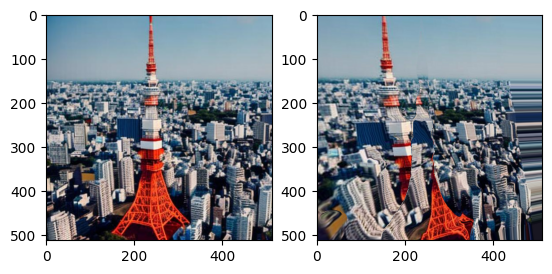

In [92]:
device = torch.device("cpu")

# calibration steps
# 1. Set phi so that the horizon is in the middle of the screen.
# 2. Adjust radius so that the object stays in the center of the screen even with a large value in theta.
# 3. Adjust theita large enough that the three-dimensional expression of the rotation is not lost, and small enough that the shape is not too distorted.
def transform_prev_img(prev_img: PIL.Image, depth: torch.Tensor, device) -> PIL.Image:
    near=200,
    far=10_000,
    fov_deg=40,
    padding_mode="border"
    sampling_mode="bicubic"

    frame_idx = 0
    prev_img_cv2 = pil2cv(prev_img)
    depth_tensor = depth

    # no translate scale
    theita_rad = math.radians(15) # amount of move camera left
    phi_rad = math.radians(8) # angle between camera and ground 

    radius = 1.7

    # x-> move camera left
    # y-> move camera up
    # z -> move camera backward :why?
    translate_xyz = [
        radius * np.sin(theita_rad),
        0,
        - (radius - radius * np.cos(theita_rad)),
    ]
    """
    translate_xyz = [
        0,
        0,
        0,
    ]
    """ 

    # x -> look up
    # y -> look right
    # z -> counterclockwise

    # rotate 1 : make camera parallel to ground
    rotate_xyz_1 = [
        phi_rad,
        0,
        0,
    ]
    rot_mat_1 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_1, device=device), "XYZ"
    ).unsqueeze(0)

    # rotate 2: make camera look right
    rotate_xyz_2 = [
        0,
        theita_rad,
        0,
    ]
    rot_mat_2 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_2, device=device), "XYZ"
    ).unsqueeze(0)

    # rotate 3: make camera angle original
    rotate_xyz_3 = [
        -phi_rad,
        0,
        0,
    ]
    rot_mat_3 = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz_3, device=device), "XYZ"
    ).unsqueeze(0)


    rot_mat = rot_mat_1 @ rot_mat_2 @ rot_mat_3
    # transform_image_3d
    torch.cuda.empty_cache()

    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]
    aspect_ratio = float(w) / float(h)
    persp_cam_old = p3d.FoVPerspectiveCameras(
        near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
    )
    persp_cam_new = p3d.FoVPerspectiveCameras(
        near,
        far,
        aspect_ratio,
        fov=fov_deg,
        degrees=True,
        R=rot_mat,
        T=torch.tensor([translate_xyz]),
        device=device,
    )
    # range of [-1,1] is important to torch grid_sample's padding handling
    y, x = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
        torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
    )
    if depth_tensor is None:
        z = torch.ones_like(x)
    else:
        z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor(
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
    ).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(
        identity_2d_batch, [1, 1, h, w], align_corners=False
    )
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)
    image_tensor = rearrange(
        torch.from_numpy(prev_img_cv2.astype(np.float32)), "h w c -> c h w"
    ).to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=sampling_mode,
        padding_mode=padding_mode,
        align_corners=False,
    )
    # convert back to cv2 style numpy array
    result_cv2 = (
        rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
        .cpu()
        .numpy()
        .astype(prev_img_cv2.dtype)
    )
    result = PIL.Image.fromarray(cv2.cvtColor(result_cv2, cv2.COLOR_BGR2RGB))
    return result

fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(transform_prev_img(img, depth, device))

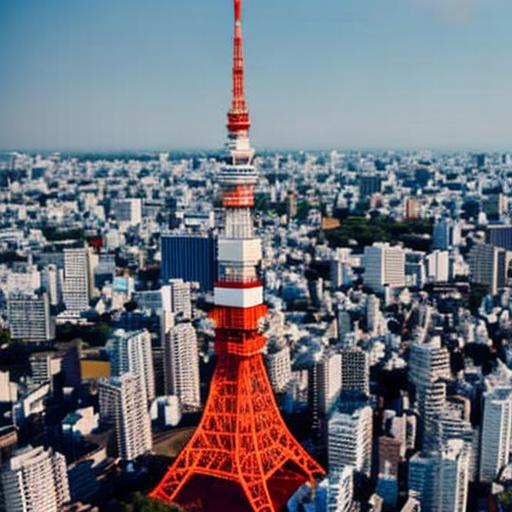

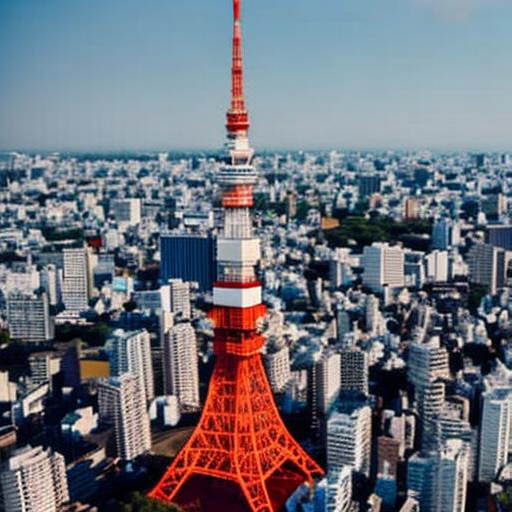